In [1]:
import sys
sys.path.append("..")


In [2]:
import os
import shutil
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
import json
import os
import time
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
from utils.split_dataset_v1 import organize_data_splits
from utils.visualize_v1 import display_class_distribution
from models.model_v1 import PlantDiseaseResNet18

from utils.grad_cam_v1 import visualize_single_image, export_batch_visualizations
from PIL import Image

from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             precision_recall_fscore_support, confusion_matrix,
                             classification_report)


from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve, average_precision_score
)

In [3]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
print(f"Running on {device}")
if torch.cuda.is_available():
    torch.cuda.set_device(device)
    print(f"Using GPU: {device}")
    print(f"GPU Name: {torch.cuda.get_device_name(device)}")
    
else:
    print("CUDA not available!")
print(f"Running on {device}")

Running on cuda:1
Using GPU: cuda:1
GPU Name: Tesla P100-PCIE-12GB
Running on cuda:1


In [4]:
destination_path="/home/sonia/RM/PlantVillage_split"


In [5]:
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [6]:
train_dir, val_dir, test_dir = [os.path.join(destination_path, s) for s in ["train", "val", "test"]]


# train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(val_dir, transform=val_test_transform)
test_dataset  = datasets.ImageFolder(test_dir, transform=val_test_transform)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


In [7]:

num_classes = len(test_dataset.classes)
model = PlantDiseaseResNet18(num_classes=num_classes, pretrained=False)


# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
model = model.to(device)

In [8]:
checkpoint_path = "../models/model_v1.pth"
out_json = "../results/metrics_v1.json"
cm_path = "../results/confusion_matrix_v1.png"
os.makedirs(os.path.dirname(out_json), exist_ok=True)

# load checkpoint if needed
if 'model' in globals() and hasattr(model, "state_dict"):
    if os.path.exists(checkpoint_path):
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        print(f"Loaded weights from {checkpoint_path}")
    model.to(device)
else:
    raise RuntimeError("Model object not found in the notebook. Define `model` before running evaluation.")

model.eval()

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy().tolist())
        all_labels.extend(labels.cpu().numpy().tolist())
        all_probs.extend(probs.cpu().numpy().tolist())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

if 'test_dataset' in globals() and hasattr(test_dataset, 'classes'):
    class_names = list(test_dataset.classes)
else:
    class_names = list(test_loader.dataset.classes) if hasattr(test_loader.dataset, 'classes') else None

if class_names is None:
    num_classes = int(max(all_labels.max(), all_preds.max()) + 1)
    class_names = [str(i) for i in range(num_classes)]

n_classes = len(class_names)

acc = accuracy_score(all_labels, all_preds)

precision, recall, f1, support = precision_recall_fscore_support(
    all_labels, all_preds, average=None, labels=np.arange(n_classes), zero_division=0
)

cm = confusion_matrix(all_labels, all_preds, labels=np.arange(n_classes))

per_class_acc = []
for i in range(n_classes):
    row_sum = cm[i].sum()
    if row_sum == 0:
        per_class_acc.append(0.0)
    else:
        per_class_acc.append(cm[i, i] / row_sum)

metrics = {
    "summary": {
        "accuracy": float(acc),
        "num_samples": int(len(all_labels))
    },
    "per_class": {},
    "confusion_matrix": cm.tolist(),
    "class_names": class_names
}

for i, cls in enumerate(class_names):
    metrics["per_class"][cls] = {
        "precision": float(precision[i]),
        "recall": float(recall[i]),
        "f1": float(f1[i]),
        "support": int(support[i]),
        "accuracy": float(per_class_acc[i])
    }

print("\n==================== MODEL EVALUATION (TEST) ====================\n")
print(f"Overall Accuracy : {acc:.4f}    (Total samples = {len(all_labels)})\n")

print("==================== PER-CLASS METRICS ====================\n")
print(f"{'Class':40s} {'Prec':>7s} {'Rec':>7s} {'F1':>7s} {'Acc':>7s} {'Support':>8s}")
print("-" * 82)
for i, cls in enumerate(class_names):
    print(f"{cls:40s} "
          f"{precision[i]:7.3f} {recall[i]:7.3f} {f1[i]:7.3f} "
          f"{per_class_acc[i]:7.3f} {support[i]:8d}")


Loaded weights from ../models/model_v1.pth

==================== MODEL EVALUATION (TEST) ====================

Overall Accuracy : 0.9759    (Total samples = 3109)

==================== PER-CLASS METRICS ====================

Class                                       Prec     Rec      F1     Acc  Support
----------------------------------------------------------------------------------
Pepper__bell___Bacterial_spot              0.968   0.987   0.977   0.987      151
Pepper__bell___healthy                     0.996   0.996   0.996   0.996      223
Potato___Early_blight                      0.974   0.993   0.983   0.993      150
Potato___Late_blight                       0.966   0.953   0.960   0.953      150
Potato___healthy                           1.000   1.000   1.000   1.000       24
Tomato_Bacterial_spot                      0.975   0.991   0.983   0.991      320
Tomato_Early_blight                        0.918   0.900   0.909   0.900      150
Tomato_Late_blight                  

In [9]:

print("Confusion matrix shape:", cm.shape)
print("Correct counts per class (diagonal):")
print({cls: int(cm[i, i]) for i, cls in enumerate(class_names)})

with open(out_json, "w") as fh:
    json.dump(metrics, fh, indent=4)
print(f"Saved metrics JSON to: {out_json}")


Confusion matrix shape: (15, 15)
Correct counts per class (diagonal):
{'Pepper__bell___Bacterial_spot': 149, 'Pepper__bell___healthy': 222, 'Potato___Early_blight': 149, 'Potato___Late_blight': 143, 'Potato___healthy': 24, 'Tomato_Bacterial_spot': 317, 'Tomato_Early_blight': 135, 'Tomato_Late_blight': 279, 'Tomato_Leaf_Mold': 142, 'Tomato_Septoria_leaf_spot': 259, 'Tomato_Spider_mites_Two_spotted_spider_mite': 249, 'Tomato__Target_Spot': 195, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 476, 'Tomato__Tomato_mosaic_virus': 57, 'Tomato_healthy': 238}
Saved metrics JSON to: ../results/metrics_v1.json


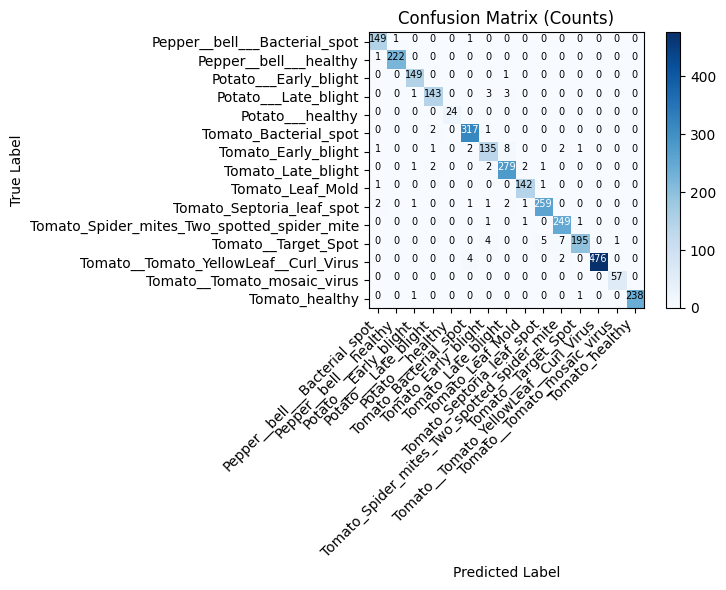

Saved: ../results/plots_test_v1/confusion_matrix_counts.png


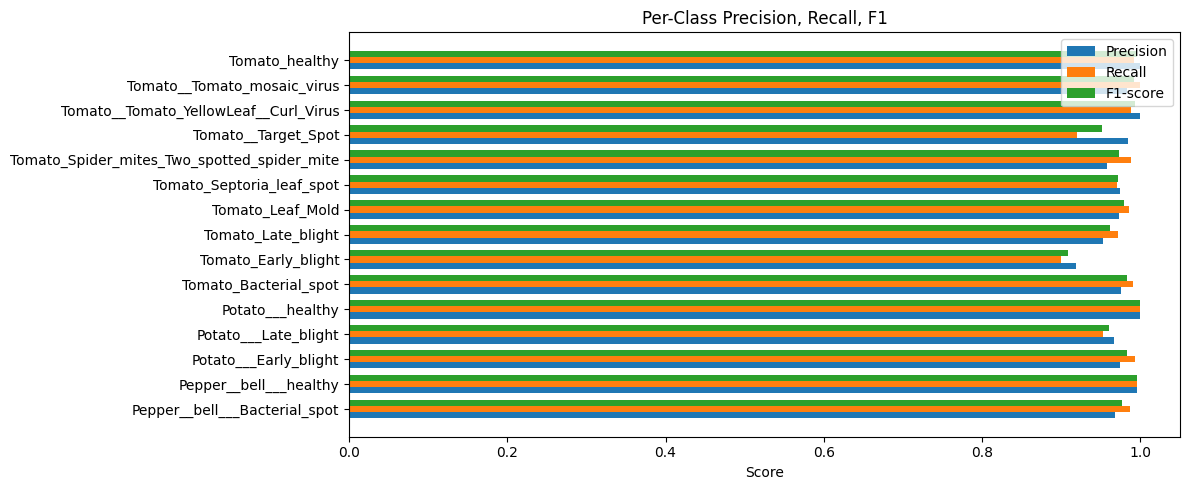

Saved: ../results/plots_test_v1/per_class_prf.png


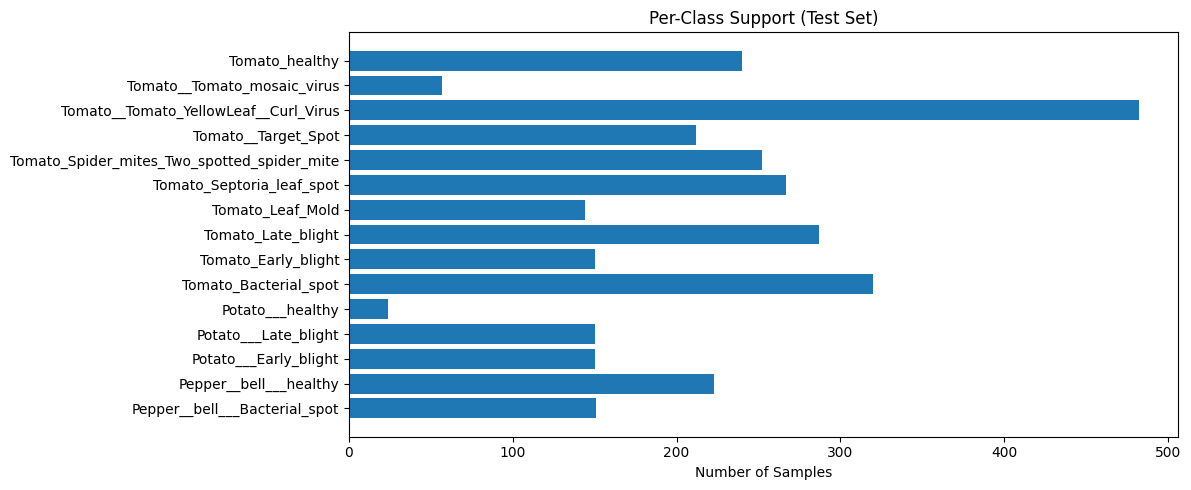

Saved: ../results/plots_test_v1/per_class_support.png


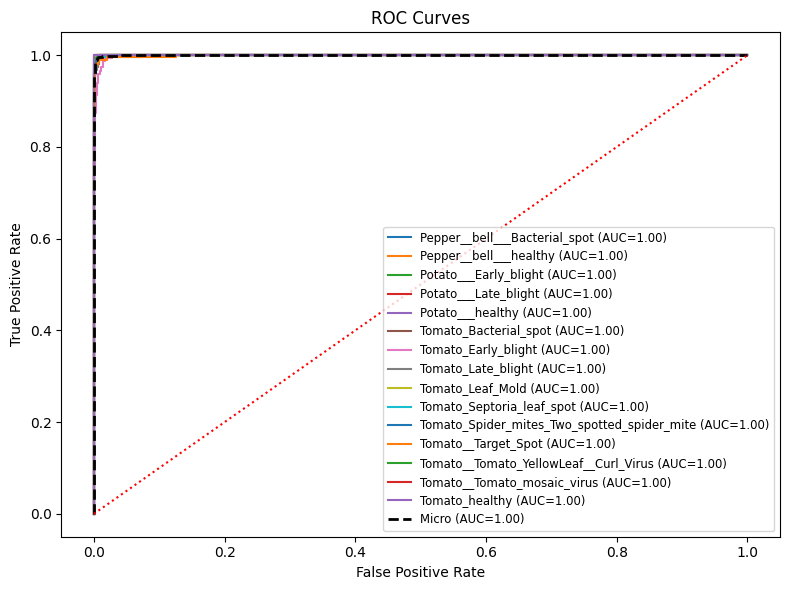

Saved: ../results/plots_test_v1/roc_curves.png


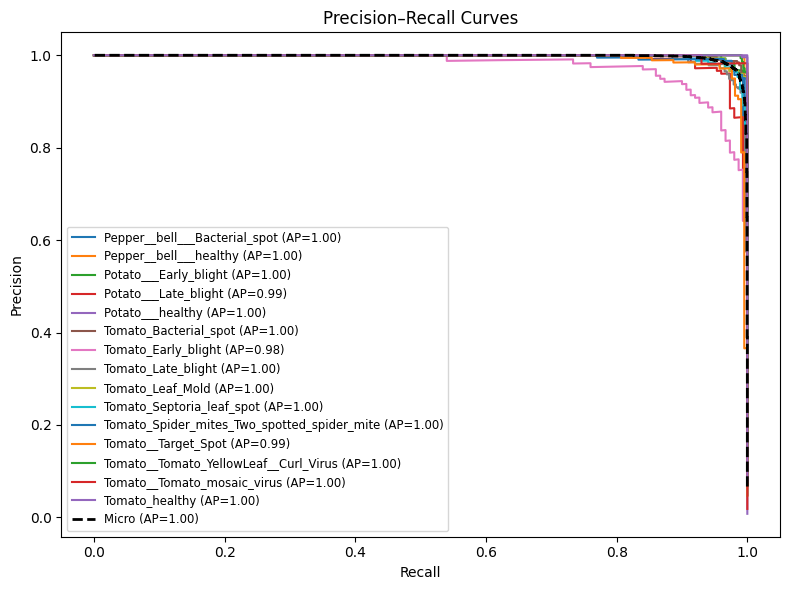

Saved: ../results/plots_test_v1/pr_curves.png

All test plots saved to: ../results/plots_test_v1


In [10]:


plots_dir = "../results/plots_test_v1"
os.makedirs(plots_dir, exist_ok=True)

if 'metrics' not in globals():
    with open("../results/metrics_v1.json", "r") as f:
        metrics = json.load(f)

if 'test_dataset' in globals():
    class_names = list(test_dataset.classes)
else:
    class_names = metrics["class_names"]

n_classes = len(class_names)

# ----- 1) Confusion Matrix -----
cm = np.array(metrics["confusion_matrix"])

plt.figure(figsize=(max(8,n_classes*0.4), max(6,n_classes*0.3)))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix (Counts)")
plt.colorbar()
ticks = np.arange(n_classes)
plt.xticks(ticks, class_names, rotation=45, ha='right')
plt.yticks(ticks, class_names)

thresh = cm.max() / 2
for i in range(n_classes):
    for j in range(n_classes):
        plt.text(j, i, str(int(cm[i,j])),
                 ha="center",
                 color="white" if cm[i,j] > thresh else "black",
                 fontsize=7)

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
p = os.path.join(plots_dir, "confusion_matrix_counts.png")
plt.savefig(p, dpi=150)
plt.show()
plt.close()
print("Saved:", p)



# ----- 3) Per-class metrics -----
prec = []
rec = []
f1 = []
support = []

for cls in class_names:
    m = metrics["per_class"][cls]
    prec.append(m["precision"])
    rec.append(m["recall"])
    f1.append(m["f1"])
    support.append(m["support"])

x = np.arange(n_classes)
width = 0.25

plt.figure(figsize=(12, max(5, n_classes*0.25)))
plt.barh(x - width, prec, height=width, label="Precision")
plt.barh(x, rec, height=width, label="Recall")
plt.barh(x + width, f1, height=width, label="F1-score")
plt.yticks(x, class_names)
plt.xlabel("Score")
plt.title("Per-Class Precision, Recall, F1")
plt.legend()
plt.tight_layout()
p = os.path.join(plots_dir, "per_class_prf.png")
plt.savefig(p, dpi=150)
plt.show()
plt.close()
print("Saved:", p)

# ----- 4) Per-class Support -----
plt.figure(figsize=(12, max(5, n_classes*0.25)))
plt.barh(class_names, support)
plt.xlabel("Number of Samples")
plt.title("Per-Class Support (Test Set)")
plt.tight_layout()
p = os.path.join(plots_dir, "per_class_support.png")
plt.savefig(p, dpi=150)
plt.show()
plt.close()
print("Saved:", p)

# ----- 5) ROC & PR curves -----
have_probs = ('all_probs' in globals()) and len(all_probs) > 0

if have_probs:
    y_true = np.array(all_labels)
    y_score = np.array(all_probs)

    Y = label_binarize(y_true, classes=np.arange(n_classes))

    # ROC curves
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(Y[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC={roc_auc:.2f})")

    fpr, tpr, _ = roc_curve(Y.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 'k--', lw=2, label=f"Micro (AUC={roc_auc:.2f})")

    plt.plot([0,1],[0,1], 'r:')
    plt.title("ROC Curves")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(fontsize="small")
    p = os.path.join(plots_dir, "roc_curves.png")
    plt.tight_layout()
    plt.savefig(p, dpi=150)
    plt.show()
    plt.close()
    print("Saved:", p)

    # Precision-Recall Curves
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        pr, rc, _ = precision_recall_curve(Y[:, i], y_score[:, i])
        ap = average_precision_score(Y[:, i], y_score[:, i])
        plt.plot(rc, pr, label=f"{class_names[i]} (AP={ap:.2f})")

    pr_micro, rc_micro, _ = precision_recall_curve(Y.ravel(), y_score.ravel())
    ap_micro = average_precision_score(Y, y_score, average="micro")
    plt.plot(rc_micro, pr_micro, 'k--', lw=2, label=f"Micro (AP={ap_micro:.2f})")

    plt.title("Precision–Recall Curves")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(fontsize="small")
    p = os.path.join(plots_dir, "pr_curves.png")
    plt.tight_layout()
    plt.savefig(p, dpi=150)
    plt.show()

    plt.close()
    print("Saved:", p)

else:
    print("Skipping ROC/PR curves — no probabilities (all_probs) available.")

print("\nAll test plots saved to:", plots_dir)


Grad Cam Visualization

In [11]:


image_preprocessing = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("../models/model_v1.pth", map_location=device))
model.to(device)
model.eval()


PlantDiseaseResNet18(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

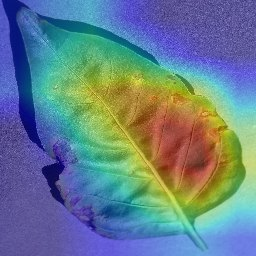

Successfully saved 20 Grad-CAM visualizations to ../results/gradcam_v1


In [12]:

test_image_path = '/home/sonia/RM/PlantVillage_split/test/Pepper__bell___Bacterial_spot/00f2e69a-1e56-412d-8a79-fdce794a17e4___JR_B.Spot 3132.JPG'
test_image = Image.open(test_image_path).convert('RGB')
overlay_result, activation_heatmap, predicted_class = visualize_single_image(
    model, test_image, image_preprocessing, computation_device=device)
display(overlay_result)

export_batch_visualizations(
    network=model,
    data_loader=val_loader,
    category_names=val_dataset.classes,
    preprocessing=image_preprocessing,
    output_directory="../results/gradcam_v1",
    sample_count=20,
    computation_device=device
)